# Advanced Lane Lines Finding

In [2]:
import os
import sys

import numpy as np
import cv2
import glob
from sklearn import linear_model
from moviepy.editor import VideoFileClip
from collections import deque

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Remove distortion

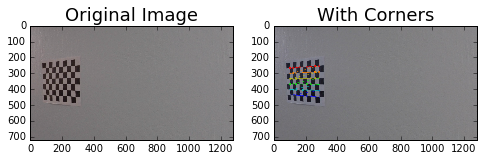

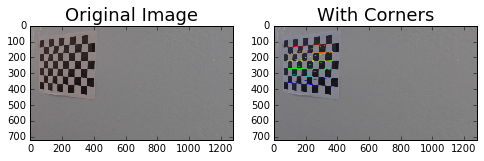

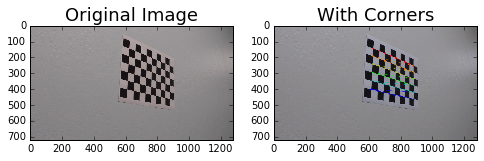

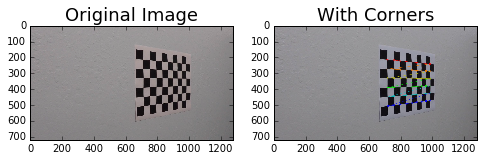

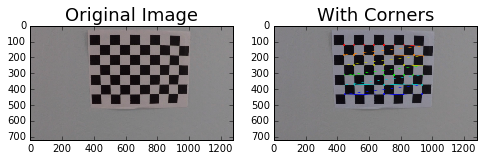

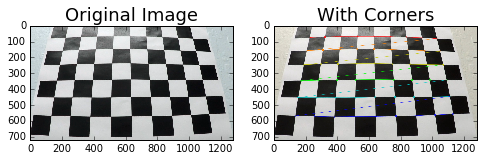

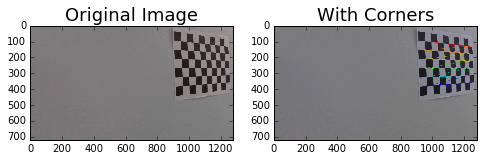

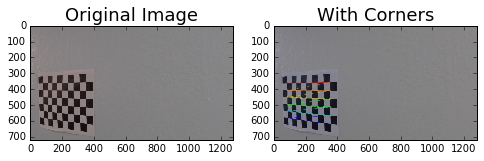

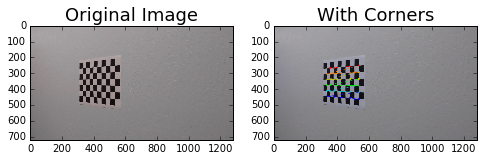

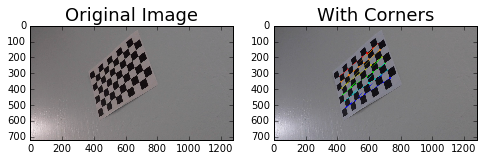

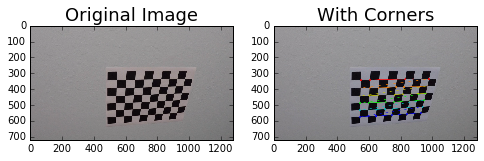

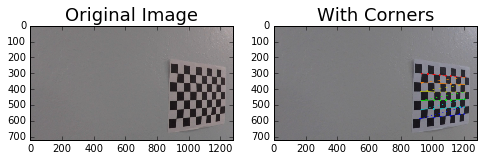

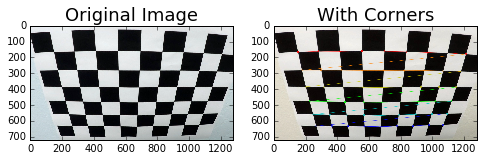

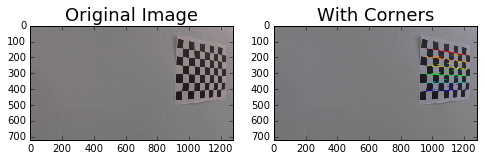

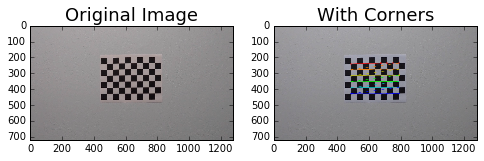

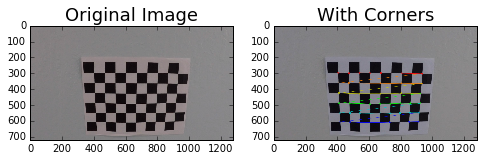

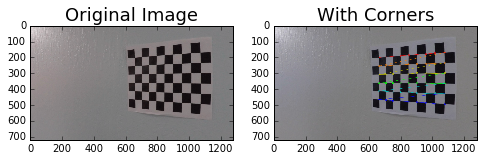

In [4]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

objp =  np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] #3d points in the real world
imgpoints = [] #2d points in the image plane

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    
    # Make a list of calibration imageson images
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) #Only if it finds the corners


    # If found, draw corners and add object points and image points.
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)
        


Next with a function called *undistortion()* I will calculate the camera calibration matrix and distortion coefficients.

In [5]:
def undistortion(image, show=True, read=True):
    if read:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    else:
        return dst

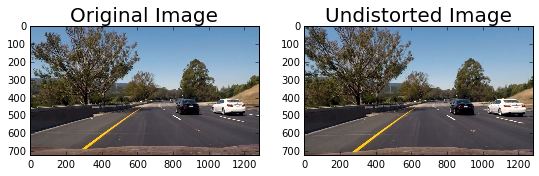

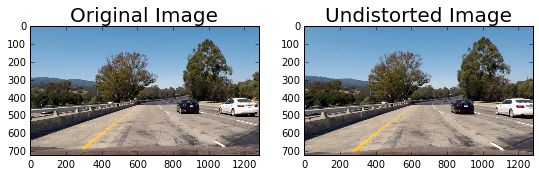

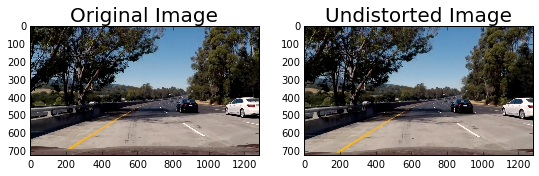

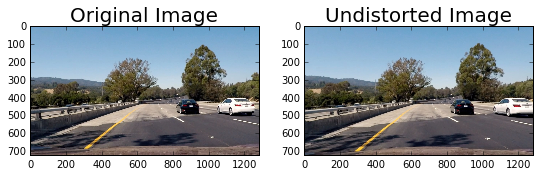

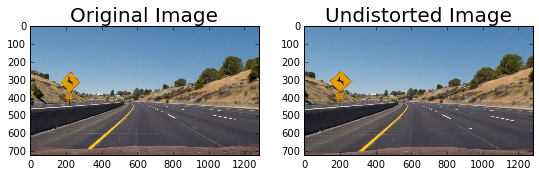

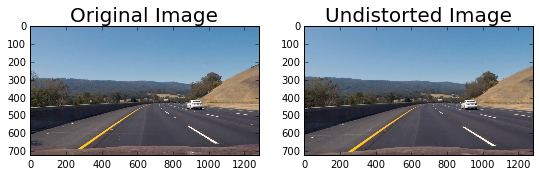

In [6]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistortion(image)

## 2. Perspective Transform

I first undistort the images and now it is usefull to transform the image to a bird's eye view. It displays the lines in a way that they are parallel to eachother. 

In [7]:
def birds_eye(img, display=True, read=True):
    if read:
        undist = undistortion(img, show = False)
    else:
        undist = undistortion(img, show = False, read = False)
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                     [1250, 720],[40,720]])
    dst = np.float32([[0, 0], [1280, 0],
                     [1250, 720], [40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M

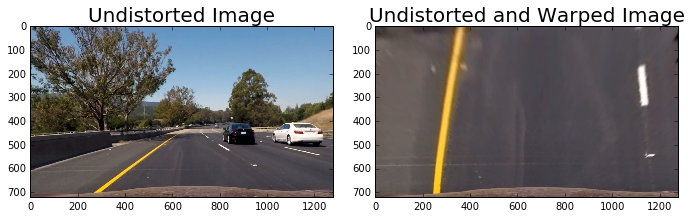

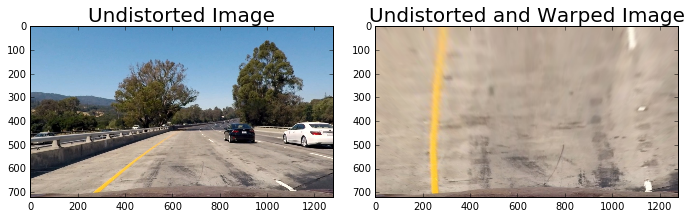

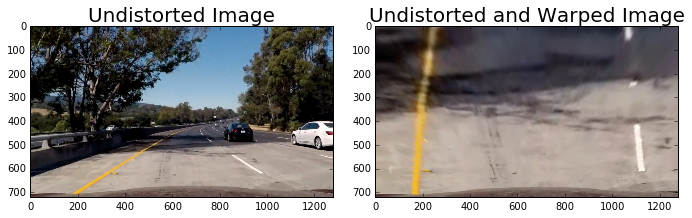

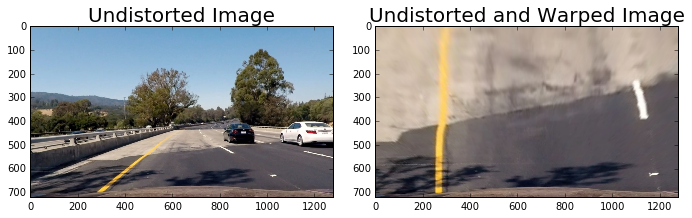

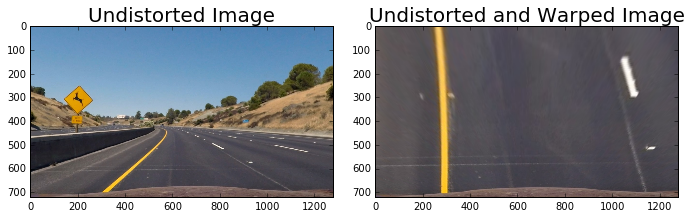

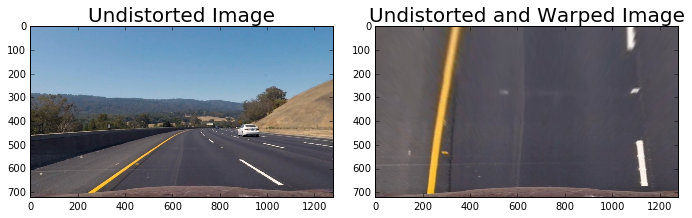

In [8]:
for image in glob.glob('test_images/test*.jpg'):
    birds_eye(image)

## 3. Binary Threshods

It is time to apply both, color and gradient thresholding. 

In [9]:
#It gets initialized just once
#I do not apply any sobel so far

def thresholds(image, show=True):

    warped, M = birds_eye(image, display=False)
    img= warped
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    #Threshold color channel
    s_thresh_min = 180 #It was 170 during the Udacity training
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel) #Transform the channel into zeros
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
       
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary) #To take an initial shape
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    
    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistortion(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('b binary threshold', fontsize=16)
        ax4.imshow(b_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('Combined color thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary
        

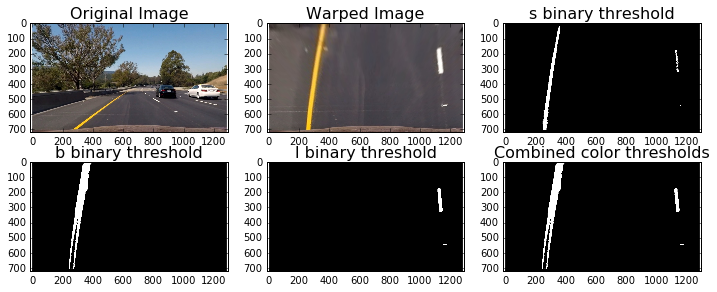

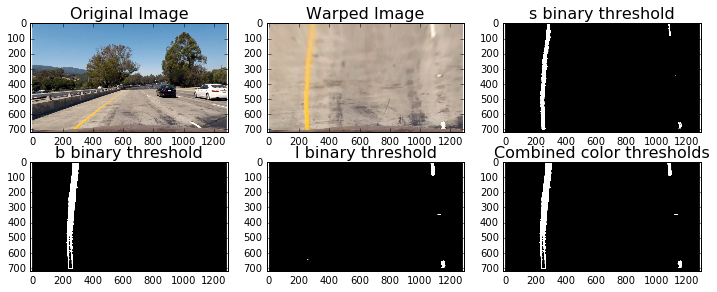

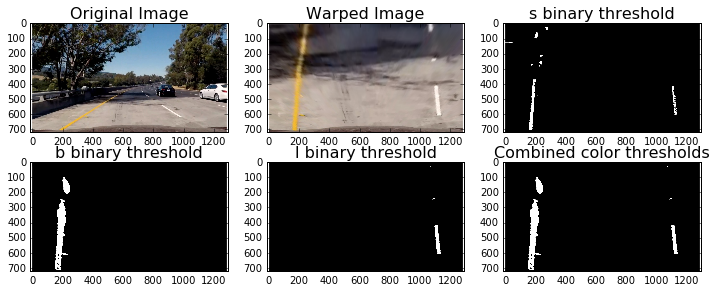

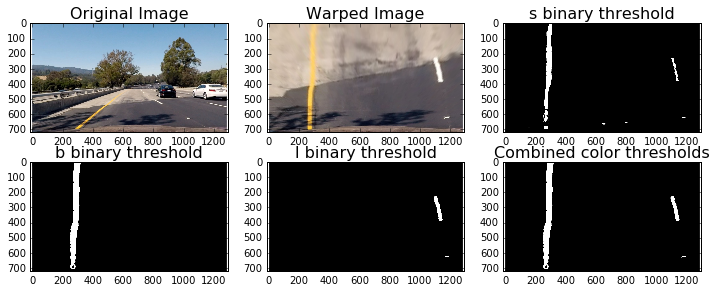

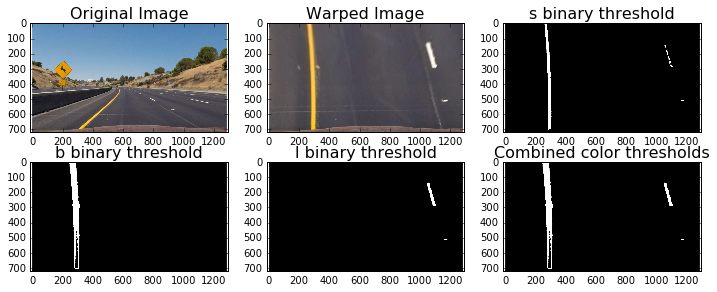

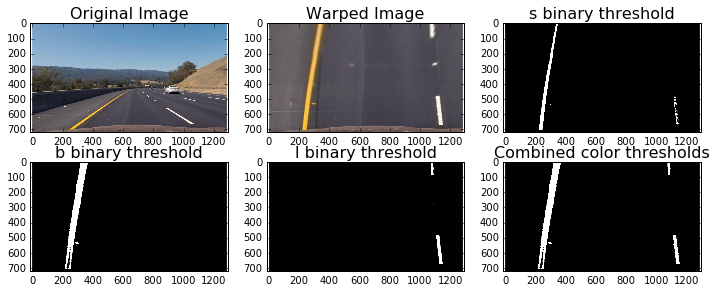

In [10]:
for image in glob.glob('test_images/test*.jpg'):
    thresholds(image)

## 4. Fitting a polynomial to the lane lines.

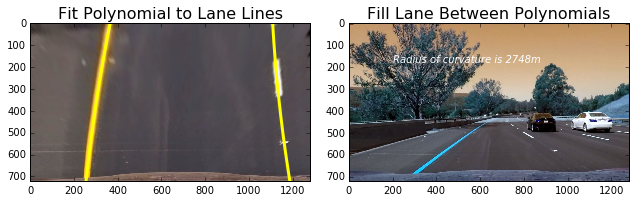

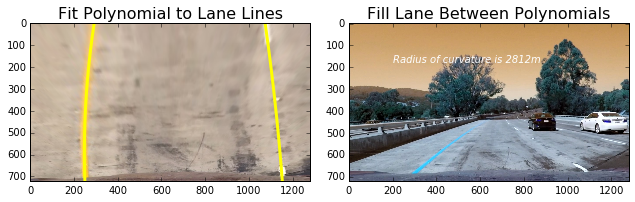

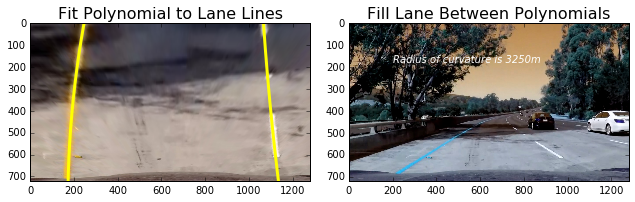

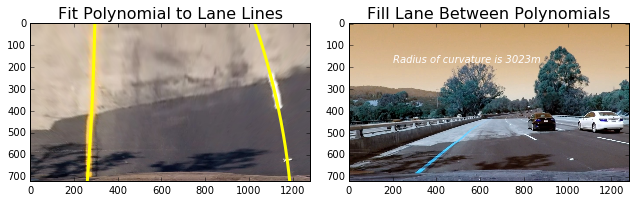

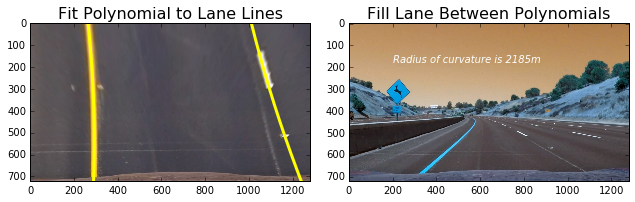

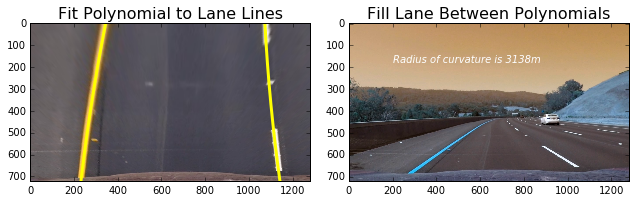

In [14]:
def fill_lane(image):
    
    combined_binary = thresholds(image, show=False)
    image = combined_binary
    rightx = []
    righty = []
    
    #It grabs only the bottom half of the image
    bottom_half = image[image.shape[0]//2:,:]
    
    #Then sum across image pixels vertically 
    histogram = np.sum(bottom_half, axis=0)

    out_img = np.dstack((image, image, image))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    plt.plot(histogram)

'''
for image in glob.glob('test_images/test*.jpg'):
    fill_lane(image)
'''   

    
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left) 
        win_y_low = binary_warped.shape[0] - (window+1)*window_height #Starting from the bottom
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(image):
    # Find our lane pixels first
    img = cv2.imread(image) #Reading the image from the path
    binary_warped = image #TO CHANGE THROUGH THE CODE LATER
    binary_warped = thresholds(binary_warped, show=False)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]) #un valor discreto
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Measure Radius of Curvature for each lane line
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)

             
    
    ###################################################################
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((birds_eye(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, ploty, color='yellow', linewidth=3)
    ax1.plot(right_fitx, ploty, color='yellow', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=16)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(img)
    ax2.set_title('Fill Lane Between Polynomials', fontsize=16)
    ax2.text(200, 175, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)),style='italic', color='white', fontsize=10)

    ###################################################################

    

    return out_img

for image in glob.glob('test_images/test*.jpg'):
#for image in glob.glob('test_images/maxresdefault.jpg'):
    out_img = fit_polynomial(image)
    
    #plt.imshow(out_img)
    '''
    f, (ax1) = plt.subplots(1, 1, figsize=(9,6))
    ax1.imshow(out_img))
    ax1.set_title('Original Image', fontsize=20)
    '''
    
#I could try to apply the convolution method.

